# Assignment 1: Learning Distributed Word Representations
**Version**: 1.0

**Version Release Date**: 2023-01-16

**Due Date**: Friday, Feb. 3, at 11:59pm

For CSC413/2516 in Winter 2023 with Professor Jimmy Ba and Professor Bo Wang

**Submission:**
You must submit two files through MarkUs: 
1. [ ] A PDF file containing your writeup, titled *a1-writeup.pdf*, which should the answers to (1) written assignment and (2) programming assignment. 
Your writeup must be typed. You may choose to directly append the PDF export of this notebook (i.e., by printing this notebook webpage as PDF) to the first half of the *a1-writeup.pdf*. There will be sections in the notebook for you to write your responses. Make sure that the relevant outputs (e.g. `print_gradients()` outputs, plots, etc.) are included and clearly visible. Do not forget to include the program traces/screenshots at the end of *a1-writeup.pdf*.
2. [ ] This `a1-code.ipynb` iPython Notebook. 

The programming assignments are individual work. See the Course Syllabus for detailed policies. 

You should attempt all questions for this assignment. Most of them can be answered at least partially even if you were unable to finish earlier questions. If you think your computational results are incorrect, please say so; that may help you get partial credit. 
    
The teaching assistants for this assignment are Denny Wu and Yangjung Ruan. Send your email with subject "*\[CSC413\] A1*" to mailto:csc413-2023-01-tas@cs.toronto.edu or post on Piazza with the tag `a1`.
    
# Introduction
In this assignment we will learn about word embeddings and make neural networks learn about words.
We could try to match statistics about the words, or we could train a network that takes a sequence of words as input and learns to predict the word that comes next.
        
This assignment will ask you to implement a linear embedding and then the backpropagation computations for a neural language model and then run some experiments to analyze the learned representation.
The amount of code you have to write is very short but each line will require you to think very carefully.
You will need to derive the updates mathematically, and then implement them using matrix and vector operations in NumPy.

# Starter code and data

First, perform the required imports for your code:


In [1]:
import collections
import pickle
import numpy as np
import os
from tqdm import tqdm
import pylab
from six.moves.urllib.request import urlretrieve
import tarfile
import sys
import itertools

TINY = 1e-30
EPS = 1e-4
nax = np.newaxis

If you're using colaboratory, this following script creates a folder - here we used 'CSC413/A1' - in order to download and store the data. If you're not using colaboratory, then set the path to wherever you want the contents to be stored at locally.

You can also manually download and unzip the data from [http://www.cs.toronto.edu/~jba/a1_data.tar.gz] and put them in the same folder as where you store this notebook. 

Feel free to use a different way to access the files *data.pk* , *partially_trained.pk*, and *raw_sentences.txt*. 

The file *raw_sentences.txt* contains the sentences that we will be using for this assignment.
These sentences are fairly simple ones and cover a vocabulary of only 250 words (+ 1 special `[MASK]` token word).





In [2]:
######################################################################
# Setup working directory
######################################################################
# Change this to a local path if running locally
%mkdir -p /content/CSC413/A1/
%cd /content/CSC413/A1

######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

/content/CSC413/A1


In [3]:
# Download the dataset and partially pre-trained model
get_file(fname='a1_data', 
                         origin='http://www.cs.toronto.edu/~jba/a1_data.tar.gz', 
                         untar=True)
drive_location = 'data'
PARTIALLY_TRAINED_MODEL = drive_location + '/' + 'partially_trained.pk'
data_location = drive_location + '/' + 'data.pk'

File path: data/a1_data.tar.gz
Extracting file.


We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets.
To inspect this data, run the following:

In [ ]:
data = pickle.load(open(data_location, 'rb'))
print(data['vocab'][0]) # First word in vocab is [MASK] 
print(data['vocab'][1]) 
print(len(data['vocab'])) # Number of words in vocab
print(data['vocab']) # All the words in vocab
print(data['train_inputs'][:10]) # 10 example training instances

In [ ]:
# Paridhika - Understanding Input Data 
print(data['vocab'][28] + " " + data['vocab'][26] + " " + data['vocab'][90] + " " + data['vocab'][144]);
print(data['vocab'][184] + " " + data['vocab'][44] + " " + data['vocab'][249] + " " + data['vocab'][117]);
print(len(data['train_inputs']))

Now `data` is a Python dict which contains the vocabulary, as well as the inputs and targets for all three splits of the data. `data['vocab']` is a list of the 251 words in the dictionary; `data['vocab'][0]` is the word with index 0, and so on. `data['train_inputs']` is a 372,500 x 4 matrix where each row gives the indices of the 4 consecutive context words for one of the 372,500 training cases.
The validation and test sets are handled analogously.

Even though you only have to modify two specific locations in the code, you may want to read through this code before starting the assignment. 

# Part 4: Linear Embedding -- GloVe (3pts)

In this section we will be implementing a simplified version of [GloVe](https://nlp.stanford.edu/pubs/glove.pdf).
Given a corpus with $V$ distinct words, we define the co-occurrence matrix $X\in \mathbb{N}^{V\times V}$ with entries $X_{ij}$ representing the frequency of the $i$-th word and $j$-th word in the corpus appearing in the same *context* - in our case the adjacent words. The co-occurrence matrix can be *symmetric* (i.e., $X_{ij} = X_{ji}$) if the order of the words do not matter, or *asymmetric* (i.e., $X_{ij} \neq X_{ji}$) if we wish to distinguish the counts for when $i$-th word appears before $j$-th word. 
GloVe aims to find a $d$-dimensional embedding of the words that preserves properties of the co-occurrence matrix by representing the $i$-th word with two $d$-dimensional vectors $\mathbf{w}_i,\tilde{\mathbf{w}}_i \in\mathbb{R}^d$, as well as two scalar biases $b_i, \tilde{b}_i\in\mathbb{R}$. Typically we have the dimension of the embedding $d$ much smaller than the number of words $V$. This objective can be written as:

$$L(\{\mathbf{w}_i,\tilde{\mathbf{w}}_i,b_i, \tilde{b}_i\}_{i=1}^V) = \sum_{i,j=1}^V (\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij})^2$$

Note that each word is represented by two $d$-dimensional embedding vectors $\mathbf{w}_i, \tilde{\mathbf{w}}_i$ and two scalar biases $b_i, \tilde{b}_i$.  When the bias terms are omitted and we tie the two embedding vectors $\mathbf{w}_i =\tilde{\mathbf{w}}_i$, then GloVe corresponds to finding a rank-$d$ symmetric factorization of the co-occurrence matrix.



Answer the following questions:

## 4.1.  GloVe Parameter Count \[0pt\] \[Type 1\]
Given the vocabulary size $V$ and embedding dimensionality $d$, how many parameters does the GloVe model have?  Note that each word in the vocabulary is associated with 2 embedding vectors and 2 biases.

4.1 **Answer**: **\*\*TODO: Write Part 4.1 answer here\*\***
<!-- Paridhika -->
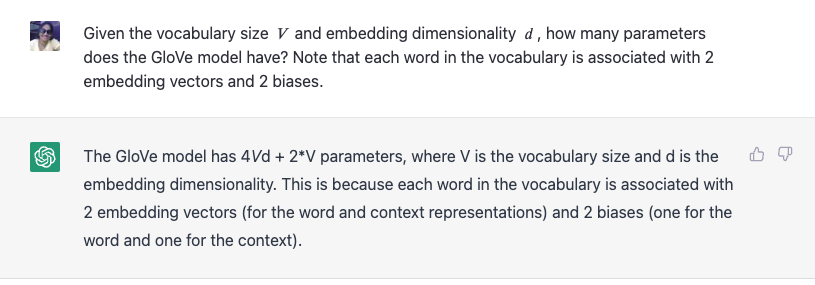


**Answer:**
The GloVe model has $4 \times V \times d + 2 \times V$ parameters, where V is the vocabulary size and d is the embedding dimensionality. This is because each word in the vocabulary is associated with 2 embedding vectors (for the word and context representations) and 2 biases (one for the word and one for the context).

## 4.2 Expression for the Vectorized Loss function [0.5pt] \[Type 1\]
 In practice, we concatenate the $V$ embedding vectors into matrices $\mathbf{W}, \tilde{\mathbf{W}} \in \mathbb{R}^{V \times d}$ and bias (column) vectors $\mathbf{b}, \tilde{\mathbf{b}} \in \mathbb{R}^{V}$, where $V$ denotes the number of distinct words as described in the introduction. Rewrite the loss function $L$ (Eq. 1) in a vectorized format in terms of $\mathbf{W}, \tilde{\mathbf{W}}, \mathbf{b}, \tilde{\mathbf{b}}, X$. You are allowed to use elementwise operations such as addition and subtraction as well as matrix operations such as the Frobenius norm and/or trace operator in your answer.
        
*Hint: Use the all-ones column vector $\mathbf{1} = [1 \dots 1]^{T} \in \mathbb{R}^{V}$. You can assume the bias vectors are column vectors, i.e. implicitly a matrix with $V$ rows and 1 column: $\mathbf{b}, \tilde{\mathbf{b}} \in \mathbb{R}^{V \times 1}$*

*Hint: To prompt a GPT-like model, try naively copy-pasting the question, generate several answers several times, and check the generated answers.*

4.2 **Answer**: 
**\*\*TODO: Write Part 4.2 answer here\*\***
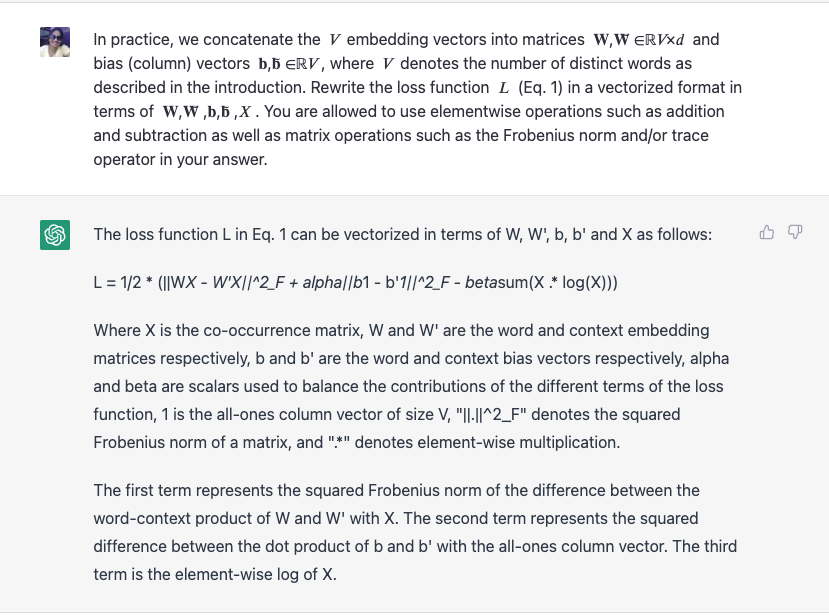
<!-- Paridhika -->
**Answer**: 


Different variants on how to express the sum over the squared elements of the matrix: 
$$
            \begin{align*}
            L(\mathbf{W},\tilde{\mathbf{W}},\mathbf{b}, \tilde{b}) &= \| \mathbf{W}\tilde{\mathbf{W}}^{\top} + \mathbf{b}\mathbf{1}^\top + \mathbf{1}\tilde{\mathbf{b}}^\top - \log X\|_F^2 \\
            &= \text{tr}\left((\mathbf{W}\tilde{\mathbf{W}}^{\top} + \mathbf{b}\mathbf{1}^\top + \mathbf{1}\tilde{\mathbf{b}}^\top - \log X)(\mathbf{W}\tilde{\mathbf{W}}^{\top} + \mathbf{b}\mathbf{1}^\top + \mathbf{1}\tilde{\mathbf{b}} - \log X)^\top \right)
            \end{align*}
$$

**
The loss function L in Eq. 1 can be vectorized in terms of $W, \tilde{W}, b, \tilde{b}$ and $X$ as follows:

$L = \frac{1}{2} \times (||WX - \tilde{W}X||^2_F + α||b \times \mathbf{1} - \tilde{b} \times \mathbf{1}||^2_F - \beta \times ∑(X .* log(X)))$

Where $X$ is the co-occurrence matrix, $W, \tilde{W}$ are the word and context embedding matrices respectively, $b$ and $\tilde{b}$ are the word and context bias vectors respectively, alpha and beta are scalars used to balance the contributions of the different terms of the loss function, 1 is the all-ones column vector of size $V, "||.||^2_F"$ denotes the squared Frobenius norm of a matrix, and ".*" denotes element-wise multiplication.

The first term represents the squared Frobenius norm of the difference between the word-context product of W and W' with X. The second term represents the squared difference between the dot product of b and b' with the all-ones column vector. The third term is the element-wise log of X.

Note that in this case, $W = \tilde{W} , b = \tilde{b}$ and the loss function is optimized to find a rank-d symmetric factorization of the co-occurrence matrix $X$.

## 4.3. Expression for gradient $\frac{\partial L}{\partial \mathbf{W}}$ \[0.5pt\] \[Type 2\]

Write the vectorized expression for $\frac{\partial L}{\partial \mathbf{W}}$, the gradient of the loss function $L$ with respect to the embedding matrix $\mathbf{W}$. The gradient should be a function of $\mathbf{W}, \tilde{\mathbf{W}}, \mathbf{b}, \tilde{\mathbf{b}}, X$. 

*Hint: Make sure that the shape of the gradient is equivalent to the shape of the matrix. You can use the all-ones vector as in the previous question.*

4.3 **Answer**: **\*\*TODO: Write Part 4.3 answer here \*\***



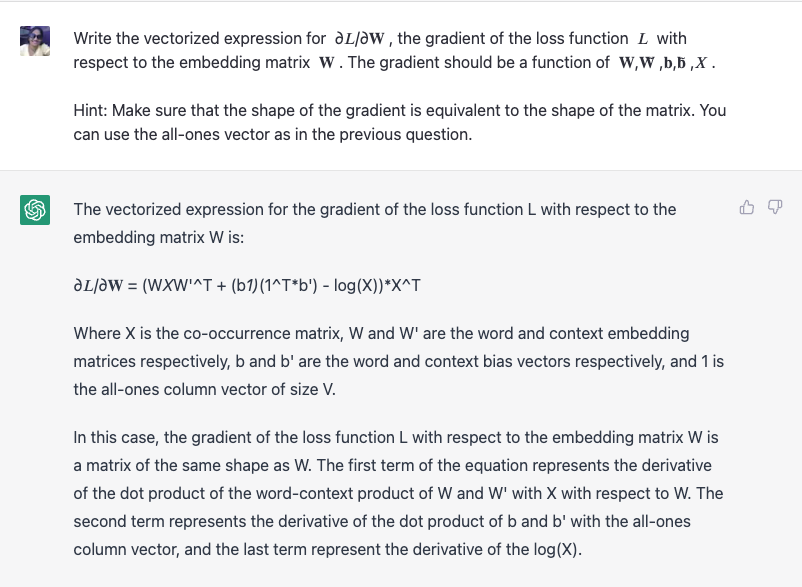

**Answer**

$$
\begin{align*}
                \nabla_\mathbf{W} L &= 2(\mathbf{W}\tilde{\mathbf{W}}^{\top} + \mathbf{b}\mathbf{1}^\top + \mathbf{1}\tilde{\mathbf{b}}^\top - X) \tilde{\mathbf{W}}    
\end{align*}            
$$


## 4.4 Implement Vectorized Loss Function [1pt] \[Type 2\]

Implement the `loss_GloVe()` function of GloVe. 

**See** `YOUR CODE HERE` **Comment below for where to complete the code**

Note that you need to implement both the loss for an *asymmetric* model (from your answer in question 1.2) and the loss for a *symmetric* model which uses the same embedding matrix $\mathbf{W}$ and bias vector $\mathbf{b}$ for the first and second word in the co-occurrence, i.e. $\tilde{\mathbf{W}} = \mathbf{W}$ and $\tilde{\mathbf{b}} = \mathbf{b}$ in the original loss.
        
*Hint: You may take advantage of NumPy's broadcasting feature for the bias vectors: https://numpy.org/doc/stable/user/basics.broadcasting.html*

We have provided a few functions for training the embedding:

*   `calculate_log_co_occurence` computes the log co-occurrence matrix of a given corpus
*   `train_GloVe` runs momentum gradient descent to optimize the embedding
*   `loss_GloVe`: **TO BE IMPLEMENTED.**
  * INPUT 
      * V x d matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional)
      * V x d matrix `W_tilde` 
      * V x 1 vector `b` (collection of $V$ bias terms)
      * V x 1 vector `b_tilde`
      * V x V log co-occurrence matrix. 
  * OUTPUT
      * loss of the GloVe objective
*   `grad_GloVe`: **TO BE IMPLEMENTED.**
  * INPUT:
      * V x d matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional), embedding for first word; 
      * V x d matrix `W_tilde`, embedding for second word; 
      * V x 1 vector `b` (collection of $V$ bias terms); 
      * V x 1 vector `b_tilde`, bias for second word; 
      * V x V log co-occurrence matrix. 
  * OUTPUT:
      * V x d matrix `grad_W` containing the gradient of the loss function w.r.t. `W`;
      * V x d matrix `grad_W_tilde` containing the gradient of the loss function w.r.t. `W_tilde`;
      * V x 1 vector `grad_b` which is the gradient of the loss function w.r.t. `b`. 
      * V x 1 vector `grad_b_tilde` which is the gradient of the loss function w.r.t. `b_tilde`. 

Run the code to compute the co-occurence matrix.

        

In [5]:
vocab_size = len(data['vocab']) # Number of vocabs

def calculate_log_co_occurence(word_data, symmetric=False):
  "Compute the log-co-occurence matrix for our data."
  log_co_occurence = np.zeros((vocab_size, vocab_size))
  for input in word_data:
    # Note: the co-occurence matrix may not be symmetric
    log_co_occurence[input[0], input[1]] += 1
    log_co_occurence[input[1], input[2]] += 1
    log_co_occurence[input[2], input[3]] += 1
    # Diagonal entries are just the frequency of the word
    log_co_occurence[input[0], input[0]] += 1
    log_co_occurence[input[1], input[1]] += 1
    log_co_occurence[input[2], input[2]] += 1
    log_co_occurence[input[3], input[3]] += 1
    # If we want symmetric co-occurence can also increment for these.
    if symmetric:
      log_co_occurence[input[1], input[0]] += 1
      log_co_occurence[input[2], input[1]] += 1
      log_co_occurence[input[3], input[2]] += 1
  delta_smoothing = 0.5  # A hyperparameter.  You can play with this if you want.
  log_co_occurence += delta_smoothing  # Add delta so log doesn't break on 0's.
  log_co_occurence = np.log(log_co_occurence)
  return log_co_occurence

In [10]:
asym_log_co_occurence_train = calculate_log_co_occurence(data['train_inputs'], symmetric=False)
asym_log_co_occurence_valid = calculate_log_co_occurence(data['valid_inputs'], symmetric=False)

**Program trace screenshot**

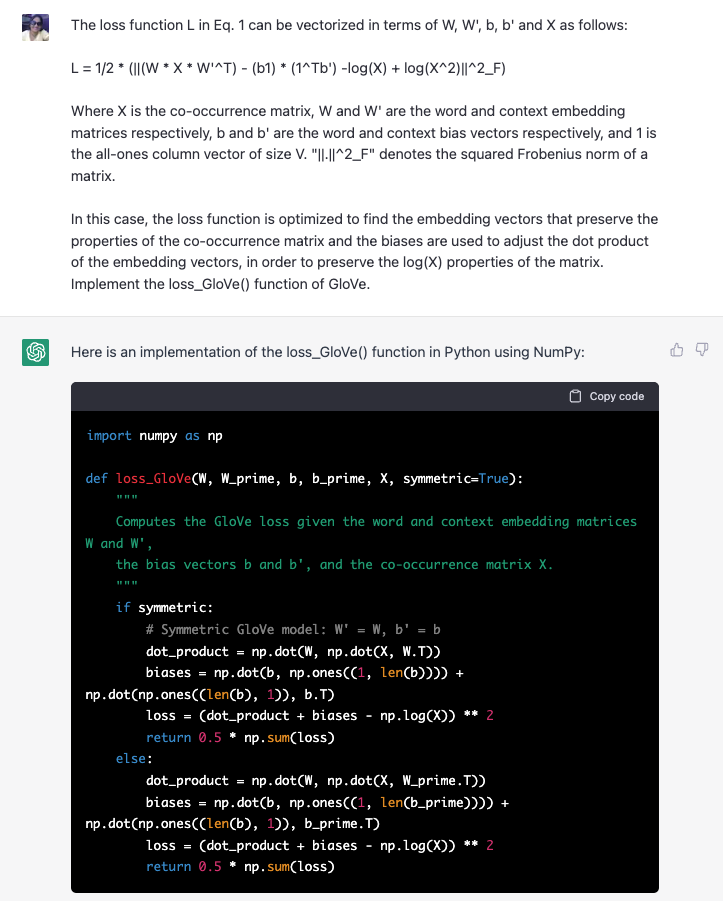



* [ ] **TO BE IMPLEMENTED**: Implement the loss function. You should vectorize the computation, i.e. not loop over every word.

*Hint: To prompt a GPT-like model, you may include in your prompt the vectorized loss formula derived in 4.2.*

In [6]:
def loss_GloVe(W, W_tilde, b, b_tilde, log_co_occurence):
  """ Compute the GloVe loss given the parameters of the model. When W_tilde 
  and b_tilde are not given, then the model is symmetric (i.e. W_tilde = W,
  b_tilde = b). 

  Args:
    W: word embedding matrix, dimension V x d where V is vocab size and d
      is the embedding dimension
    W_tilde: for asymmetric GloVe model, a second word embedding matrix, with
      dimensions V x d
    b: bias vector, dimension V x 1
    b_tilde: for asymmetric GloVe model, a second bias vector, dimension V x 1
    log_co_occurence: V x V log co-occurrence matrix (log X)
  
  Returns:
    loss: a scalar (float) for GloVe loss
  """
  n,_ = log_co_occurence.shape
  # Symmetric Case, no W_tilde and b_tilde
  if W_tilde is None and b_tilde is None:
    # Symmetric model
    ###########################   YOUR CODE HERE  ##############################
    loss = np.sum((W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)**2)
    # print(loss)
    ############################################################################
  else: 
    # Asymmetric model
    ###########################   YOUR CODE HERE  ##############################
    loss = np.sum((W @ W_tilde.T + b @ np.ones([1,n]) + np.ones([n,1])@b_tilde.T - log_co_occurence)**2)
    # print(loss)
    ############################################################################
  return loss


## 4.5.  Implement the gradient update of GloVe. \[1pt\] \[Type 2\]

Implement the `grad_GloVe()` function which computes the gradient of GloVe.

**See** `YOUR CODE HERE` **Comment below for where to complete the code**


Again, note that you need to implement the gradient for both the symmetric and asymmetric models. 

* [ ] **TO BE IMPLEMENTED**: Calculate the gradient of the loss function w.r.t. the parameters $W$, $\tilde{W}$, $\mathbf{b}$, and $\mathbf{b}$. You should vectorize the computation, i.e. not loop over every word.

*Hint: To prompt a GPT-like model, you may include the GloVe loss implementation in 4.4.*

**Program trace screenshot**

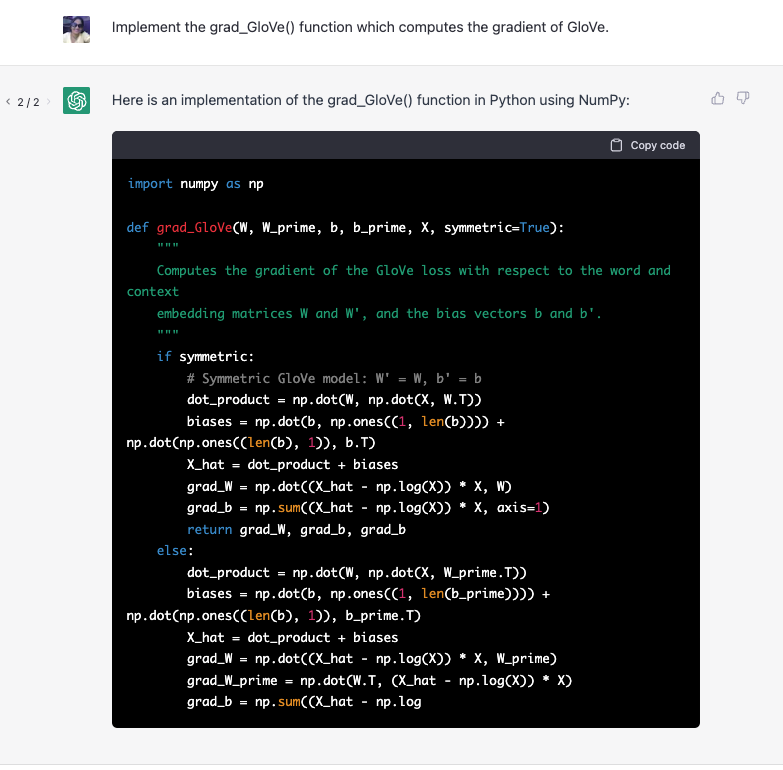

In [7]:
def grad_GloVe(W, W_tilde, b, b_tilde, log_co_occurence):
  """Return the gradient of GloVe objective w.r.t its parameters
  Args:
    W: word embedding matrix, dimension V x d where V is vocab size and d
      is the embedding dimension
    W_tilde: for asymmetric GloVe model, a second word embedding matrix, with
      dimensions V x d
    b: bias vector, dimension V x 1
    b_tilde: for asymmetric GloVe model, a second bias vector, dimension V x 1
    log_co_occurence: V x V log co-occurrence matrix (log X)
  
  Returns:
    grad_W: gradient of the loss wrt W, dimension V x d
    grad_W_tilde: gradient of the loss wrt W_tilde, dimension V x d. Return 
      None if W_tilde is None.
    grad_b: gradient of the loss wrt b, dimension V x 1
    grad_b_tilde: gradient of the loss wrt b, dimension V x 1. Return 
      None if b_tilde is None.
  """
  n,_ = log_co_occurence.shape
  
  loss = loss_GloVe(W, W_tilde, b, b_tilde, log_co_occurence)
  if not W_tilde is None and not b_tilde is None:
  ###########################   YOUR CODE HERE  ##############################
    loss = (W @ W_tilde.T + b @ np.ones([1,n]) + np.ones([n,1])@b_tilde.T - log_co_occurence)
    grad_W = 2 * loss @ W_tilde
    grad_W_tilde = 2 * (loss.T @ W)
    grad_b = 2 * loss @ np.ones([n,1])
    grad_b_tilde = 2 * (loss.T @ np.ones([n,1]))
  ############################################################################
  else:
    grad_W_tilde = None
    grad_b_tilde = None
    
    # Method 1: Add both summation over rows and over columns
    loss = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)
    grad_W = 2 * (loss.T @ W) + 2 * (loss @  W)
    grad_b = 2 * loss @ np.ones([n,1]) + 2 * (loss.T @ np.ones([n,1]))
    
    # Method 2: Symmetrize the log_co_occurence and multiply by 2
    loss = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - 0.5*(log_co_occurence + log_co_occurence.T))
    grad_W = 4 * (loss.T @ W)
    grad_b = 4 * (np.ones([1,n]) @ loss).T
    
  return grad_W, grad_W_tilde, grad_b, grad_b_tilde

To help you debug your GloVe gradient computation, we have included a finite-difference gradien checker function defined below:

In [8]:
def relative_error(a, b):
    return np.abs(a - b) / (np.abs(a) + np.abs(b))
 
def check_GloVe_gradients(W, W_tilde, b, b_tilde, log_co_occurence):
    """Check the computed gradients using finite differences."""
    np.random.seed(0)
    np.seterr(all='ignore')  # suppress a warning which is harmless

    # Obtain the analytical gradient
    grad_W, grad_W_tilde, grad_b, grad_b_tilde = grad_GloVe(W, W_tilde, b, b_tilde, log_co_occurence)
    grads_dict = {"W":grad_W, "W_tilde": grad_W_tilde, 
                      "b": grad_b, "b_tilde": grad_b_tilde}

    params_dict = {"W":W, "W_tilde":W_tilde, "b":b, "b_tilde":b_tilde}

    # Check that the shapes of the parameters and gradients match
    for name in params_dict:
      if params_dict[name] is None:
        continue
      dims = params_dict[name].shape
      is_matrix = (len(dims) == 2)
      if not is_matrix:
        print()

      if params_dict[name].shape != grads_dict[name].shape:
        print('The gradient for {} should be size {} but is actually {}.'.format(
            name, params_dict[name].shape, grads_dict[name].shape))
        return

      # Run finite difference for that param
      for count in range(1000):
        if is_matrix:
            slc = np.random.randint(0, dims[0]), np.random.randint(0, dims[1])
        else:
            slc = np.random.randint(dims[0])
        
        params_dict_plus = params_dict.copy()
        params_dict_plus[name] = params_dict[name].copy()
        params_dict_plus[name][slc] += EPS
        obj_plus = loss_GloVe(params_dict_plus["W"], 
                              params_dict_plus["W_tilde"], 
                              params_dict_plus["b"],
                              params_dict_plus["b_tilde"],
                              log_co_occurence)

        params_dict_minus = params_dict.copy()
        params_dict_minus[name] = params_dict[name].copy()
        params_dict_minus[name][slc] -= EPS
        obj_minus = loss_GloVe(params_dict_minus["W"], 
                              params_dict_minus["W_tilde"], 
                              params_dict_minus["b"],
                              params_dict_minus["b_tilde"],
                              log_co_occurence)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        exact = grads_dict[name][slc]
        rel = relative_error(empirical, exact)
        if rel > 5e-4:
          print('The loss derivative has a relative error of {}, which is too large for param {}.'.format(rel, name))
          return False
      print('The gradient for {} looks OK.'.format(name))

Run the cell below to check if your `grad_GloVe` function passes the checker. The function will check for both the symmetric and asymmetric loss, for each of the parameter variables whether its gradient computation looks ok. The expected output is:

```
Checking asymmetric loss gradient...
The gradient for W looks OK.
The gradient for W_tilde looks OK.
The gradient for b looks OK.
The gradient for b_tilde looks OK.

Checking symmetric loss gradient...
The gradient for W looks OK.
The gradient for b looks OK.
```

Note: If you update the `grad_GloVe` cell while debugging, make sure to run the `grad_GloVe` cell again before re-running the cell below to check the gradient.

- [ ] **TODO**: Run this cell below to check the gradient implementation

In [11]:
np.random.seed(0)

# Store the final losses for graphing
init_variance = 0.05  # A hyperparameter.  You can play with this if you want.
embedding_dim = 16
W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
b = init_variance * np.random.normal(size=(vocab_size, 1))
b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))

print("Checking asymmetric loss gradient...")
check_GloVe_gradients(W, W_tilde, b, b_tilde, asym_log_co_occurence_train)

print("\nChecking symmetric loss gradient...")
check_GloVe_gradients(W, None, b, None, asym_log_co_occurence_train)

Checking asymmetric loss gradient...
The gradient for W looks OK.
The gradient for W_tilde looks OK.
The gradient for b looks OK.
The gradient for b_tilde looks OK.

Checking symmetric loss gradient...
The gradient for W looks OK.
The gradient for b looks OK.


Now that you have checked taht the gradient is correct, we define the training function for the model given the initial weights and ground truth log co-occurence matrix:

In [12]:
def train_GloVe(W, W_tilde, b, b_tilde, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=False):
  "Traing W and b according to GloVe objective."
  n,_ = log_co_occurence_train.shape
  learning_rate = 0.05 / n  # A hyperparameter.  You can play with this if you want.
  train_loss_list = np.zeros(n_epochs)
  valid_loss_list = np.zeros(n_epochs)
  vocab_size = log_co_occurence_train.shape[0]

  for epoch in range(n_epochs):
    grad_W, grad_W_tilde, grad_b, grad_b_tilde = grad_GloVe(W, W_tilde, b, b_tilde, log_co_occurence_train)
    W = W - learning_rate * grad_W
    b = b - learning_rate * grad_b
    if not grad_W_tilde is None and not grad_b_tilde is None:
      W_tilde = W_tilde - learning_rate * grad_W_tilde
      b_tilde = b_tilde - learning_rate * grad_b_tilde
    train_loss, valid_loss = loss_GloVe(W, W_tilde, b, b_tilde, log_co_occurence_train), loss_GloVe(W, W_tilde, b, b_tilde, log_co_occurence_valid)
    if do_print:
      print(f"Average Train Loss: {train_loss / vocab_size}, Average valid loss: {valid_loss / vocab_size}, grad_norm: {np.sum(grad_W**2)}")
    train_loss_list[epoch] = train_loss / vocab_size
    valid_loss_list[epoch] = valid_loss / vocab_size

  return W, W_tilde, b, b_tilde, train_loss_list, valid_loss_list

- [ ] **TODO**: Run this cell below to run an experiment training GloVe model 

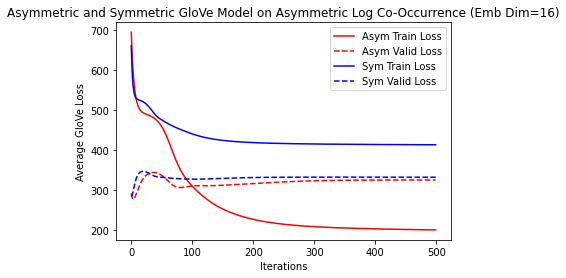

In [13]:
### TODO: Run this cell ###
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.

# Store the final losses for graphing
do_print = False  # If you want to see diagnostic information during training
init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
embedding_dim = 16
W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
b = init_variance * np.random.normal(size=(vocab_size, 1))
b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))

# Run the training for the asymmetric and symmetric GloVe model
Asym_W_final, Asym_W_tilde_final, Asym_b_final, Asym_b_tilde_final, Asym_train_loss_list, Asym_valid_loss_list = train_GloVe(W, W_tilde, b, b_tilde, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
Sym_W_final, Sym_W_tilde_final, Sym_b_final, Sym_b_tilde_final, Sym_train_loss_list, Sym_valid_loss_list = train_GloVe(W, None, b, None, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)

# Plot the resulting training curve
pylab.plot(Asym_train_loss_list, label="Asym Train Loss", color='red')
pylab.plot(Asym_valid_loss_list, label="Asym Valid Loss", color='red', linestyle='--')
pylab.plot(Sym_train_loss_list, label="Sym Train Loss", color='blue')
pylab.plot(Sym_valid_loss_list, label="Sym Valid Loss", color='blue', linestyle='--')
pylab.xlabel("Iterations")
pylab.ylabel("Average GloVe Loss")
pylab.title("Asymmetric and Symmetric GloVe Model on Asymmetric Log Co-Occurrence (Emb Dim={})".format(embedding_dim))
pylab.legend()

## 4.6 Effects of a buggy implementation [0pt] \[Type 2\]

Suppose that during the implementation, you initialized the weight embedding matrix $\mathbf{W}$ and $\tilde{\mathbf{W}}$ with the same initial values (i.e., $\mathbf{W} = \tilde{\mathbf{W}} = \mathbf{W}_0$).

What will happen to the values of $\mathbf{W}$ and $\tilde{\mathbf{W}}$ over the course of training. Will they stay equal to each other, or diverge from each other? Explain your answer briefly. 
        
*Hint: Consider the gradient $\frac{\partial L}{\partial \mathbf{W}}$ versus  $\frac{\partial L}{\partial \tilde{\mathbf{W}}}$*

4.6 **Answer**: **\*\*TODO: Write Part 4.6 answer here \*\***


## 4.7. Effect of embedding dimension $d$ \[0pt\] \[Type 3\]
Train the both the symmetric and asymmetric GLoVe model with varying dimensionality $d$ by running the cell below. Comment on:
1. Which $d$ leads to optimal validation performance for the asymmetric and symmetric models?
2. Why does / doesn't larger $d$ always lead to better validation error? 
3. Which model is performing better, and why?


4.7 Answer: **\*\*TODO: Write Part 4.7 answer here\*\***

Train the GloVe model for a range of embedding dimensions

In [ ]:
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.
embedding_dims = np.array([1, 2, 10, 128, 256])  # Play with this
# Store the final losses for graphing
asymModel_asymCoOc_final_train_losses, asymModel_asymCoOc_final_val_losses = [], []
symModel_asymCoOc_final_train_losses, symModel_asymCoOc_final_val_losses = [], []
Asym_W_final_2d, Asym_b_final_2d, Asym_W_tilde_final_2d, Asym_b_tilde_final_2d = None, None, None, None
W_final_2d, b_final_2d = None, None
do_print = False  # If you want to see diagnostic information during training

for embedding_dim in tqdm(embedding_dims):
  init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
  W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
  W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
  b = init_variance * np.random.normal(size=(vocab_size, 1))
  b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))
  if do_print:
    print(f"Training for embedding dimension: {embedding_dim}")
  
  # Train Asym model on Asym Co-Oc matrix
  Asym_W_final, Asym_W_tilde_final, Asym_b_final, Asym_b_tilde_final, train_loss_list, valid_loss_list = train_GloVe(W, W_tilde, b, b_tilde, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
  if embedding_dim == 2:
    # Save a parameter copy if we are training 2d embedding for visualization later
    Asym_W_final_2d = Asym_W_final
    Asym_W_tilde_final_2d = Asym_W_tilde_final
    Asym_b_final_2d = Asym_b_final
    Asym_b_tilde_final_2d = Asym_b_tilde_final
  asymModel_asymCoOc_final_train_losses += [train_loss_list[-1]]
  asymModel_asymCoOc_final_val_losses += [valid_loss_list[-1]]
  if do_print:
    print(f"Final validation loss: {valid_loss}")
  
  # Train Sym model on Asym Co-Oc matrix
  W_final, W_tilde_final, b_final, b_tilde_final, train_loss_list, valid_loss_list = train_GloVe(W, None, b, None, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
  if embedding_dim == 2:
    # Save a parameter copy if we are training 2d embedding for visualization later
    W_final_2d = W_final
    b_final_2d = b_final
  symModel_asymCoOc_final_train_losses += [train_loss_list[-1]]
  symModel_asymCoOc_final_val_losses += [valid_loss_list[-1]]
  if do_print:
    print(f"Final validation loss: {valid_loss}")

Plot the training and validation losses against the embedding dimension.

In [ ]:
pylab.loglog(embedding_dims, asymModel_asymCoOc_final_train_losses, label="Asymmetric Model / Asymmetric Co-Oc", linestyle="--")
pylab.loglog(embedding_dims, symModel_asymCoOc_final_train_losses , label="Symmetric Model / Asymmetric Co-Oc")
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Training Loss")
pylab.legend()

In [ ]:
pylab.loglog(embedding_dims, asymModel_asymCoOc_final_val_losses, label="Asymmetric Model / Asymmetric Co-Oc", linestyle="--")
pylab.loglog(embedding_dims, symModel_asymCoOc_final_val_losses , label="Sym Model / Asymmetric Co-Oc")
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Validation Loss")
pylab.legend(loc="upper left")

# Part 5: Neural Language Model Network architecture (2pt)
See the handout for the written questions in this part.

## Answer the following questions

## 5.1. Number of parameters in neural network model \[1pt\] \[Type 2\]

The trainable parameters of the model consist of 3 weight matrices and 2 sets of biases. What is the total number of trainable parameters in the model, as a function of $V,N,D,H$? 

In the diagram given, which part of the model (i.e., `word_embbeding_weights`, `embed_to_hid_weights`, `hid_to_output_weights`, `hid_bias`, or `output_bias`) has the largest number of trainable parameters if we have the constraint that $V \gg H > D > N$? Note: The symbol $\gg$ means ``much greater than" Explain your reasoning. 


5.1 Answer: **\*\*TODO: Write Part 5.1 answer here\*\***

## 5.2 Number of parameters in $n$-gram model \[1pt\] \[Type 1\]
Another method for predicting the next words is an *n-gram model*, which was mentioned in Lecture 3. If we wanted to use an n-gram model with the same context length $N-1$ as our network (since we mask 1 of the $N$ words in our input), we'd need to store the counts of all possible $N$-grams. If we stored all the counts explicitly and suppose that we have $V$ words in the dictionary, how many entries would this table have?

5.2 Answer: **\*\*TODO: Write Part 5.2 answer here\*\***


## 5.3. Comparing neural network and $n$-gram model scaling \[0pt\] \[Type 2\]
How do the parameters in the neural network model scale with the number of context words $N$ versus how the number of entries in the $n$-gram model scale with $N$? [0pt]

5.3 Answer: **\*\*TODO: Write Part 5.3 answer here\*\***

# Part 6: Training the Neural Network (2pts)


In this part, you will learn to implement and train the neural language model from Figure 1. As described in the previous section, during training, we randomly sample one of the $N$ context words to replace with a `[MASK]` token. The goal is for the network to predict the word that was masked, at the corresponding output word position. In practice, this `[MASK]` token is assigned the index 0 in our dictionary. The weights $W^{(2)}$ = `hid_to_output_weights` now has the shape $NV \times H$, as the output layer has $NV$ neurons, where the first $V$ output units are for predicting the first word, then the next $V$ are for predicting the second word, and so on. 
        We call this as *concatenating* output units across all word positions, i.e. the $(v + nV)$-th column is for the word $v$ in vocabulary for the $n$-th output word position. 
        Note here that the softmax is applied in chunks of $V$ as well, to give a valid probability distribution over the $V$ words (For simplicity we also include the `[MASK]` token as one of the possible prediction even though we know the target should not be this token). Only the output word positions that were masked in the input are included in the cross entropy loss calculation:

$$C = -\sum_{i}^{B}\sum_{n}^{N}\sum_{v}^{V} m^{(i)}_{n} (t^{(i)}_{v + nV} \log y^{(i)}_{v + nV})$$

Where:
*  $y^{(i)}_{v + nV}$ denotes the output probability prediction from the neural network for the $i$-th training example for the word $v$ in the $n$-th output word. Denoting $z$ as the logits output, we define the output probability $y$ as a softmax on $z$ over contiguous chunks of $V$ units (see also Figure 1): 

$$y^{(i)}_{v + nV} = \frac{e^{z^{(i)}_{v+nV}}}{\sum_{l}^{V} e^{z^{(i)}_{l+nV}}}$$
* $t^{(i)}_{v + nV}  \in \{0,1\}$ is 1 if for the $i$-th training example, the word $v$ is the $n$-th word in context
* $m^{(i)}_{n} \in \{0,1\}$ is a mask that is set to 1 if we are predicting the $n$-th word position for the $i$-th example (because we had masked that word in the input), and 0 otherwise

There are three classes defined in this part: `Params`, `Activations`, `Model`.
You will make changes to `Model`, but it may help to read through `Params` and `Activations` first.

In [ ]:
class Params(object):
    """A class representing the trainable parameters of the model. This class has five fields:
    
           word_embedding_weights, a matrix of size V x D, where V is the number of words in the vocabulary
                   and D is the embedding dimension.
           embed_to_hid_weights, a matrix of size H x ND, where H is the number of hidden units. The first D
                   columns represent connections from the embedding of the first context word, the next D columns
                   for the second context word, and so on. There are N context words.
           hid_bias, a vector of length H
           hid_to_output_weights, a matrix of size NV x H
           output_bias, a vector of length NV"""

    def __init__(self, word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                 hid_bias, output_bias):
        self.word_embedding_weights = word_embedding_weights
        self.embed_to_hid_weights = embed_to_hid_weights
        self.hid_to_output_weights = hid_to_output_weights
        self.hid_bias = hid_bias
        self.output_bias = output_bias

    def copy(self):
        return self.__class__(self.word_embedding_weights.copy(), self.embed_to_hid_weights.copy(),
                              self.hid_to_output_weights.copy(), self.hid_bias.copy(), self.output_bias.copy())

    @classmethod
    def zeros(cls, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes all weights and biases to 0."""
        word_embedding_weights = np.zeros((vocab_size, embedding_dim))
        embed_to_hid_weights = np.zeros((num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.zeros((vocab_size * context_len, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    @classmethod
    def random_init(cls, init_wt, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes weights to small random values and biases to 0."""
        word_embedding_weights = np.random.normal(0., init_wt, size=(vocab_size, embedding_dim))
        embed_to_hid_weights = np.random.normal(0., init_wt, size=(num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.random.normal(0., init_wt, size=(vocab_size * context_len, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    ###### The functions below are Python's somewhat oddball way of overloading operators, so that
    ###### we can do arithmetic on Params instances. You don't need to understand this to do the assignment.

    def __mul__(self, a):
        return self.__class__(a * self.word_embedding_weights,
                              a * self.embed_to_hid_weights,
                              a * self.hid_to_output_weights,
                              a * self.hid_bias,
                              a * self.output_bias)

    def __rmul__(self, a):
        return self * a

    def __add__(self, other):
        return self.__class__(self.word_embedding_weights + other.word_embedding_weights,
                              self.embed_to_hid_weights + other.embed_to_hid_weights,
                              self.hid_to_output_weights + other.hid_to_output_weights,
                              self.hid_bias + other.hid_bias,
                              self.output_bias + other.output_bias)

    def __sub__(self, other):
        return self + -1. * other

In [ ]:
class Activations(object):
    """A class representing the activations of the units in the network. This class has three fields:

        embedding_layer, a matrix of B x ND matrix (where B is the batch size, D is the embedding dimension,
                and N is the number of input context words), representing the activations for the embedding 
                layer on all the cases in a batch. The first D columns represent the embeddings for the 
                first context word, and so on.
        hidden_layer, a B x H matrix representing the hidden layer activations for a batch
        output_layer, a B x V matrix representing the output layer activations for a batch"""

    def __init__(self, embedding_layer, hidden_layer, output_layer):
        self.embedding_layer = embedding_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

def get_batches(inputs, batch_size, shuffle=True):
    """Divide a dataset (usually the training set) into mini-batches of a given size. This is a
    'generator', i.e. something you can use in a for loop. You don't need to understand how it
    works to do the assignment."""

    if inputs.shape[0] % batch_size != 0:
        raise RuntimeError('The number of data points must be a multiple of the batch size.')
    num_batches = inputs.shape[0] // batch_size

    if shuffle:
        idxs = np.random.permutation(inputs.shape[0])
        inputs = inputs[idxs, :]

    for m in range(num_batches):
        yield inputs[m * batch_size:(m + 1) * batch_size, :]

In this part of the assignment, you implement a method which computes the gradient using backpropagation.
To start you out, the *Model* class contains several important methods used in training:


*   `compute_activations` computes the activations of all units on a given input batch
*   `compute_loss_derivative` computes the gradient with respect to the output logits $\frac{\partial C}{\partial z}$
*   `evaluate` computes the average cross-entropy loss for a given set of inputs and targets

You will need to complete the implementation of two additional methods to complete the training, and print the outputs of the gradients. 

## 6.1 Implement gradient with respect to output layer inputs [0.5pt] \[Type 2\]
Implement a vectorized `compute_loss` function, which computes the total cross-entropy loss on a mini-batch according to Eq. 2. Look for the `## YOUR CODE HERE ##` comment for where to complete the code. The docstring provides a description of the inputs to the function. 



## 6.2 Implement gradient with respect to parameters [1pt] \[Type 2\]
`back_propagate` is the function which computes the gradient of the loss with respect to model parameters using backpropagation.
It uses the derivatives computed by *compute_loss_derivative*.
Some parts are already filled in for you, but you need to compute the matrices of derivatives for `embed_to_hid_weights`, `hid_bias`, `hid_to_output_weights`, and `output_bias`.
These matrices have the same sizes as the parameter matrices (see previous section). These matrices have the same sizes as the parameter matrices. Look for the `## YOUR CODE HERE ##` comment for where to complete the code.

In order to implement backpropagation efficiently, you need to express the computations in terms of matrix operations, rather than *for* loops.
You should first work through the derivatives on pencil and paper.
First, apply the chain rule to compute the derivatives with respect to individual units, weights, and biases.
Next, take the formulas you've derived, and express them in matrix form.
You should be able to express all of the required computations using only matrix multiplication, matrix transpose, and elementwise operations --- no *for* loops!
If you want inspiration, read through the code for *Model.compute_activations* and try to understand how the matrix operations correspond to the computations performed by all the units in the network.

*Hint: Your implementations should also be similar to* `hid_to_output_weights_grad`,`hid_bias_grad` *in the same function call*

*Hint: To prompt a GPT-like model, you may only include functions that are relevent to the implementation in your prompt.*
 

In [ ]:
class Model(object):
    """A class representing the language model itself. This class contains various methods used in training
    the model and visualizing the learned representations. It has two fields:

        params, a Params instance which contains the model parameters
        vocab, a list containing all the words in the dictionary; vocab[0] is the word with index
               0, and so on."""

    def __init__(self, params, vocab):
        self.params = params
        self.vocab = vocab

        self.vocab_size = len(vocab)
        self.embedding_dim = self.params.word_embedding_weights.shape[1]
        self.embedding_layer_dim = self.params.embed_to_hid_weights.shape[1]
        self.context_len = self.embedding_layer_dim // self.embedding_dim
        self.num_hid = self.params.embed_to_hid_weights.shape[0]

    def copy(self):
        return self.__class__(self.params.copy(), self.vocab[:])

    @classmethod
    def random_init(cls, init_wt, vocab, context_len, embedding_dim, num_hid):
        """Constructor which randomly initializes the weights to Gaussians with standard deviation init_wt
        and initializes the biases to all zeros."""
        params = Params.random_init(init_wt, len(vocab), context_len, embedding_dim, num_hid)
        return Model(params, vocab)

    def indicator_matrix(self, targets, mask_zero_index=True):
        """Construct a matrix where the (v + n*V)th entry of row i is 1 if the n-th target word
         for example i is v, and all other entries are 0.

         Note: if the n-th target word index is 0, this corresponds to the [MASK] token,
               and we set the entry to be 0. 
        """
        batch_size, context_len = targets.shape
        expanded_targets = np.zeros((batch_size, context_len * len(self.vocab)))
        offset = np.repeat((np.arange(context_len) * len(self.vocab))[np.newaxis, :], batch_size, axis=0) # [[0, V, 2V], [0, V, 2V], ...]
        targets_offset = targets + offset

        for c in range(context_len):
          expanded_targets[np.arange(batch_size), targets_offset[:,c]] = 1.
          if mask_zero_index:
            # Note: Set the targets with index 0, V, 2V to be zero since it corresponds to the [MASK] token
            expanded_targets[np.arange(batch_size), offset[:,c]] = 0. 
        return expanded_targets

    def compute_loss_derivative(self, output_activations, expanded_target_batch, target_mask):
        """Compute the gradient of cross-entropy loss wrt output logits z
        
            For example:

         [y_{0} ....  y_{V-1}] [y_{V}, ..., y_{2*V-1}] [y_{2*V} ... y_{i,3*V-1}] [y_{3*V} ... y_{i,4*V-1}] 
                  
         Where for column v + n*V,

            y_{v + n*V} = e^{z_{v + n*V}} / \sum_{m=0}^{V-1} e^{z_{m + n*V}}, for n=0,...,N-1

        This function should return a dC / dz matrix of size [batch_size x (vocab_size * context_len)],
        where each row i in dC / dz has columns 0 to V-1 containing the gradient the 1st output 
        context word from i-th training example, then columns vocab_size to 2*vocab_size - 1 for the 2nd
        output context word of the i-th training example, etc.
        
        C is the loss function summed acrossed all examples as well:

            C = -\sum_{i,j,n} mask_{i,n} (t_{i, j + n*V} log y_{i, j + n*V}), for j=0,...,V, and n=0,...,N

        where mask_{i,n} = 1 if the i-th training example has n-th context word as the target, 
        otherwise mask_{i,n} = 0.
        
        Args:
          output_activations: A [batch_size x (context_len * vocab_size)] matrix, 
              for the activations of the output layer, i.e. the y_j's.
          expanded_target_batch: A [batch_size x (context_len * vocab_size)] matrix, 
              where expanded_target_batch[i,n*V:(n+1)*V] is the indicator vector for 
              the n-th context target word position, i.e. the (i, j + n*V) entry is 1 if the 
              i'th example, the context word at position n is j, and 0 otherwise.
          target_mask: A [batch_size x context_len x 1] tensor, where target_mask[i,n] = 1 
              if for the i'th example the n-th context word is a target position, otherwise 0
        
        Outputs:
          loss_derivative: A [batch_size x (context_len * vocab_size)] matrix,
              where loss_derivative[i,0:vocab_size] contains the gradient
              dC / dz_0 for the i-th training example gradient for 1st output 
              context word, and loss_derivative[i,vocab_size:2*vocab_size] for 
              the 2nd output context word of the i-th training example, etc.
        """
        # Reshape output_activations and expanded_target_batch and use broadcasting
        output_activations_reshape = output_activations.reshape(-1, self.context_len, len(self.vocab))
        expanded_target_batch_reshape = expanded_target_batch.reshape(-1, self.context_len, len(self.vocab))
        gradient_masked_reshape =  target_mask * (output_activations_reshape - expanded_target_batch_reshape)
        gradient_masked = gradient_masked_reshape.reshape(-1, self.context_len * len(self.vocab))
        return gradient_masked

    def compute_loss(self, output_activations, expanded_target_batch, target_mask):
        """Compute the total cross entropy loss over a mini-batch.

        Args:
          output_activations: [batch_size x (context_len * vocab_size)] matrix, 
                for the activations of the output layer, i.e. the y_j's.
          expanded_target_batch: [batch_size (context_len * vocab_size)] matrix, 
                where expanded_target_batch[i,n*V:(n+1)*V] is the indicator vector for 
                the n-th context target word position, i.e. the (i, j + n*V) entry is 1 if the 
                i'th example, the context word at position n is j, and 0 otherwise. matrix obtained
          target_mask: A [batch_size x context_len x 1] tensor, where target_mask[i,n,0] = 1 
                if for the i'th example the n-th context word is a target position, otherwise 0
        
        Returns:
          loss: a scalar for the  total cross entropy loss over the batch, 
                defined in Part 3
        """
        ###########################   YOUR CODE HERE  ##############################
        pass
        ############################################################################
        return loss

    def compute_activations(self, inputs):
        """Compute the activations on a batch given the inputs. Returns an Activations instance.
        You should try to read and understand this function, since this will give you clues for
        how to implement back_propagate."""

        batch_size = inputs.shape[0]
        if inputs.shape[1] != self.context_len:
            raise RuntimeError('Dimension of the input vectors should be {}, but is instead {}'.format(
                self.context_len, inputs.shape[1]))

        # Embedding layer
        # Look up the input word indices in the word_embedding_weights matrix
        embedding_layer_state = self.params.word_embedding_weights[inputs.reshape([-1]), :].reshape([batch_size, self.embedding_layer_dim])

        # Hidden layer
        inputs_to_hid = np.dot(embedding_layer_state, self.params.embed_to_hid_weights.T) + \
                        self.params.hid_bias
        # Apply logistic activation function
        hidden_layer_state = 1. / (1. + np.exp(-inputs_to_hid))

        # Output layer
        inputs_to_softmax = np.dot(hidden_layer_state, self.params.hid_to_output_weights.T) + \
                            self.params.output_bias

        # Subtract maximum.
        # Remember that adding or subtracting the same constant from each input to a
        # softmax unit does not affect the outputs. So subtract the maximum to
        # make all inputs <= 0. This prevents overflows when computing their exponents.
        inputs_to_softmax -= inputs_to_softmax.max(1).reshape((-1, 1))

        # Take softmax along each V chunks in the output layer
        output_layer_state = np.exp(inputs_to_softmax)
        output_layer_state_shape = output_layer_state.shape
        output_layer_state = output_layer_state.reshape((-1, self.context_len, len(self.vocab)))
        output_layer_state /= output_layer_state.sum(axis=-1, keepdims=True) # Softmax along vocab of each target word
        output_layer_state = output_layer_state.reshape(output_layer_state_shape) # Flatten back to 2D matrix

        return Activations(embedding_layer_state, hidden_layer_state, output_layer_state)

    def back_propagate(self, input_batch, activations, loss_derivative):
        """Compute the gradient of the loss function with respect to the trainable parameters
        of the model.
        
        Part of this function is already completed, but you need to fill in the derivative
        computations for hid_to_output_weights_grad, output_bias_grad, embed_to_hid_weights_grad,
        and hid_bias_grad. See the documentation for the Params class for a description of what
        these matrices represent.

        Args: 
          input_batch: A [batch_size x context_length] matrix containing the 
              indices of the context words
          activations: an Activations object representing the output of 
              Model.compute_activations
          loss_derivative:  A [batch_size x (context_len * vocab_size)] matrix,
              where loss_derivative[i,0:vocab_size] contains the gradient
              dC / dz_0 for the i-th training example gradient for 1st output 
              context word, and loss_derivative[i,vocab_size:2*vocab_size] for 
              the 2nd output context word of the i-th training example, etc.
              Obtained from calling compute_loss_derivative()
          
        Returns:
          Params object containing the gradient for word_embedding_weights_grad, 
              embed_to_hid_weights_grad, hid_to_output_weights_grad,
              hid_bias_grad, output_bias_grad  
        """

        # The matrix with values dC / dz_j, where dz_j is the input to the jth hidden unit,
        # i.e. h_j = 1 / (1 + e^{-z_j})
        hid_deriv = np.dot(loss_derivative, self.params.hid_to_output_weights) \
                    * activations.hidden_layer * (1. - activations.hidden_layer)

        
        hid_to_output_weights_grad = np.dot(loss_derivative.T, activations.hidden_layer)
        
        ###########################   YOUR CODE HERE  ##############################
        # output_bias_grad = ...
        # embed_to_hid_weights_grad = ...
        ############################################################################
        
        hid_bias_grad = hid_deriv.sum(0)

        # The matrix of derivatives for the embedding layer
        embed_deriv = np.dot(hid_deriv, self.params.embed_to_hid_weights)

        # Word Embedding Weights gradient
        word_embedding_weights_grad = np.dot(self.indicator_matrix(input_batch.reshape([-1,1]), mask_zero_index=False).T, 
                                                 embed_deriv.reshape([-1, self.embedding_dim]))

        return Params(word_embedding_weights_grad, embed_to_hid_weights_grad, hid_to_output_weights_grad,
                      hid_bias_grad, output_bias_grad)

    def sample_input_mask(self, batch_size):
        """Samples a binary mask for the inputs of size batch_size x context_len
        For each row, at most one element will be 1.
        """
        mask_idx = np.random.randint(self.context_len, size=(batch_size,))
        mask = np.zeros((batch_size, self.context_len), dtype=np.int)# Convert to one hot B x N, B batch size, N context len
        mask[np.arange(batch_size), mask_idx] = 1
        return mask
    
    def evaluate(self, inputs, batch_size=100):
        """Compute the average cross-entropy over a dataset.

            inputs: matrix of shape D x N"""

        ndata = inputs.shape[0]

        total = 0.
        for input_batch in get_batches(inputs, batch_size):
            mask = self.sample_input_mask(batch_size)
            input_batch_masked = input_batch * (1 - mask)
            activations = self.compute_activations(input_batch_masked)
            expanded_target_batch = self.indicator_matrix(input_batch)
            target_mask = np.expand_dims(mask, axis=2)
            cross_entropy = self.compute_loss(activations.output_layer, expanded_target_batch, target_mask)
            total += cross_entropy

        return total / float(ndata)

    def display_nearest_words(self, word, k=10):
        """List the k words nearest to a given word, along with their distances."""

        if word not in self.vocab:
            print('Word "{}" not in vocabulary.'.format(word))
            return

        # Compute distance to every other word.
        idx = self.vocab.index(word)
        word_rep = self.params.word_embedding_weights[idx, :]
        diff = self.params.word_embedding_weights - word_rep.reshape((1, -1))
        distance = np.sqrt(np.sum(diff ** 2, axis=1))

        # Sort by distance.
        order = np.argsort(distance)
        order = order[1:1 + k]  # The nearest word is the query word itself, skip that.
        for i in order:
            print('{}: {}'.format(self.vocab[i], distance[i]))

    def word_distance(self, word1, word2):
        """Compute the distance between the vector representations of two words."""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))

        idx1, idx2 = self.vocab.index(word1), self.vocab.index(word2)
        word_rep1 = self.params.word_embedding_weights[idx1, :]
        word_rep2 = self.params.word_embedding_weights[idx2, :]
        diff = word_rep1 - word_rep2
        return np.sqrt(np.sum(diff ** 2))

## 6.3 Print the gradients [0.5pt] \[Type 4\]

To make your life easier, we have provided the routine `check_gradients`, which checks your gradients using finite differences.
        You should make sure this check passes before continuing with the assignment. Once `check_gradients()` passes, call `print_gradients()` and include its output in your write-up. 

In [ ]:
def relative_error(a, b):
    return np.abs(a - b) / (np.abs(a) + np.abs(b))


def check_output_derivatives(model, input_batch, target_batch, mask):
    def softmax(z):
        z = z.copy()
        z -= z.max(-1, keepdims=True)
        y = np.exp(z)
        y /= y.sum(-1, keepdims=True)
        return y

    batch_size = input_batch.shape[0]
    z = np.random.normal(size=(batch_size, model.context_len, model.vocab_size))
    y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
    z = z.reshape((batch_size, model.context_len * model.vocab_size))

    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = np.expand_dims(mask, axis=2)
    loss_derivative = model.compute_loss_derivative(y, expanded_target_batch, target_mask)

    if loss_derivative is None:
        print('Loss derivative not implemented yet.')
        return False

    if loss_derivative.shape != (batch_size, model.vocab_size * model.context_len):
        print('Loss derivative should be size {} but is actually {}.'.format(
            (batch_size, model.vocab_size), loss_derivative.shape))
        return False

    def obj(z):
        z = z.reshape((-1, model.context_len, model.vocab_size))
        y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
        return model.compute_loss(y, expanded_target_batch, target_mask)

    for count in range(1000):
        i, j = np.random.randint(0, loss_derivative.shape[0]), np.random.randint(0, loss_derivative.shape[1])

        z_plus = z.copy()
        z_plus[i, j] += EPS
        obj_plus = obj(z_plus)

        z_minus = z.copy()
        z_minus[i, j] -= EPS
        obj_minus = obj(z_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        rel = relative_error(empirical, loss_derivative[i, j])
        if rel > 1e-4:
            print('The loss derivative has a relative error of {}, which is too large.'.format(rel))
            return False

    print('The loss derivative looks OK.')
    return True


def check_param_gradient(model, param_name, input_batch, target_batch, mask):
    activations = model.compute_activations(input_batch)
    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = np.expand_dims(mask, axis=2)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, target_mask)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    def obj(model):
        activations = model.compute_activations(input_batch)
        return model.compute_loss(activations.output_layer, expanded_target_batch, target_mask)

    dims = getattr(model.params, param_name).shape
    is_matrix = (len(dims) == 2)

    if getattr(param_gradient, param_name).shape != dims:
        print('The gradient for {} should be size {} but is actually {}.'.format(
            param_name, dims, getattr(param_gradient, param_name).shape))
        return

    for count in range(1000):
        if is_matrix:
            slc = np.random.randint(0, dims[0]), np.random.randint(0, dims[1])
        else:
            slc = np.random.randint(dims[0])

        model_plus = model.copy()
        getattr(model_plus.params, param_name)[slc] += EPS
        obj_plus = obj(model_plus)

        model_minus = model.copy()
        getattr(model_minus.params, param_name)[slc] -= EPS
        obj_minus = obj(model_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        exact = getattr(param_gradient, param_name)[slc]
        rel = relative_error(empirical, exact)
        if rel > 5e-4:
            print('The loss derivative has a relative error of {}, which is too large for param {}.'.format(rel, param_name))
            return False

    print('The gradient for {} looks OK.'.format(param_name))


def load_partially_trained_model():
    obj = pickle.load(open(PARTIALLY_TRAINED_MODEL, 'rb'))
    params = Params(obj['word_embedding_weights'], obj['embed_to_hid_weights'],
                                   obj['hid_to_output_weights'], obj['hid_bias'],
                                   obj['output_bias'])
    vocab = obj['vocab']
    return Model(params, vocab)


def check_gradients():
    """Check the computed gradients using finite differences."""
    np.random.seed(0)

    np.seterr(all='ignore')  # suppress a warning which is harmless

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs = data_obj['train_inputs']
    input_batch = train_inputs[:100, :]
    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
 
    if not check_output_derivatives(model, input_batch_masked, input_batch, mask):
        return

    for param_name in ['word_embedding_weights', 'embed_to_hid_weights', 'hid_to_output_weights',
                       'hid_bias', 'output_bias']:
        check_param_gradient(model, param_name, input_batch_masked, input_batch, mask)


def print_gradients():
    """Print out certain derivatives for grading."""
    np.random.seed(0)

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs = data_obj['train_inputs']
    input_batch = train_inputs[:100, :]

    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
    activations = model.compute_activations(input_batch_masked)
    expanded_target_batch = model.indicator_matrix(input_batch)
    target_mask = np.expand_dims(mask, axis=2)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, target_mask)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    print('loss_derivative[46, 785]', loss_derivative[46, 785])
    print('loss_derivative[46, 766]', loss_derivative[46, 766])
    print('loss_derivative[5, 42]', loss_derivative[5, 42])
    print('loss_derivative[5, 31]', loss_derivative[5, 31])
    print()
    print('param_gradient.word_embedding_weights[27, 2]', param_gradient.word_embedding_weights[27, 2])
    print('param_gradient.word_embedding_weights[43, 3]', param_gradient.word_embedding_weights[43, 3])
    print('param_gradient.word_embedding_weights[22, 4]', param_gradient.word_embedding_weights[22, 4])
    print('param_gradient.word_embedding_weights[2, 5]', param_gradient.word_embedding_weights[2, 5])
    print()
    print('param_gradient.embed_to_hid_weights[10, 2]', param_gradient.embed_to_hid_weights[10, 2])
    print('param_gradient.embed_to_hid_weights[15, 3]', param_gradient.embed_to_hid_weights[15, 3])
    print('param_gradient.embed_to_hid_weights[30, 9]', param_gradient.embed_to_hid_weights[30, 9])
    print('param_gradient.embed_to_hid_weights[35, 21]', param_gradient.embed_to_hid_weights[35, 21])
    print()
    print('param_gradient.hid_bias[10]', param_gradient.hid_bias[10])
    print('param_gradient.hid_bias[20]', param_gradient.hid_bias[20])
    print()
    print('param_gradient.output_bias[0]', param_gradient.output_bias[0])
    print('param_gradient.output_bias[1]', param_gradient.output_bias[1])
    print('param_gradient.output_bias[2]', param_gradient.output_bias[2])
    print('param_gradient.output_bias[3]', param_gradient.output_bias[3])


In [ ]:
# Run this to check if your implement gradients matches the finite difference within tolerance
# Note: this may take a few minutes to go through all the checks
check_gradients()                                   

In [ ]:
# Run this to print out the gradients
print_gradients()

## 6.4 Run model training [0pt]

Once you've implemented the gradient computation, you'll need to train the model.
The function *train* implements the main training procedure.
It takes two arguments:


*   `embedding_dim`: The number of dimensions in the distributed representation.
*   `num_hid`: The number of hidden units


As the model trains, the script prints out some numbers that tell you how well the training is going.
It shows:


*   The cross entropy on the last 100 mini-batches of the training set. This is shown after every 100 mini-batches.
*   The cross entropy on the entire validation set every 1000 mini-batches of training.

At the end of training, this function shows the cross entropies on the training, validation and test sets.
It will return a *Model* instance.

In [ ]:
_train_inputs = None
_train_targets = None
_vocab = None

DEFAULT_TRAINING_CONFIG = {'batch_size': 100,  # the size of a mini-batch
                           'learning_rate': 0.1,  # the learning rate
                           'momentum': 0.9,  # the decay parameter for the momentum vector
                           'epochs': 50,  # the maximum number of epochs to run
                           'init_wt': 0.01,  # the standard deviation of the initial random weights
                           'context_len': 4,  # the number of context words used
                           'show_training_CE_after': 100,  # measure training error after this many mini-batches
                           'show_validation_CE_after': 1000,  # measure validation error after this many mini-batches
                           }


def find_occurrences(word1, word2, word3):
    """Lists all the words that followed a given tri-gram in the training set and the number of
    times each one followed it."""

    # cache the data so we don't keep reloading
    global _train_inputs, _train_targets, _vocab
    if _train_inputs is None:
        data_obj = pickle.load(open(data_location, 'rb'))
        _vocab = data_obj['vocab']
        _train_inputs, _train_targets = data_obj['train_inputs'], data_obj['train_targets']

    if word1 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
    if word2 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
    if word3 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

    idx1, idx2, idx3 = _vocab.index(word1), _vocab.index(word2), _vocab.index(word3)
    idxs = np.array([idx1, idx2, idx3])

    matches = np.all(_train_inputs == idxs.reshape((1, -1)), 1)

    if np.any(matches):
        counts = collections.defaultdict(int)
        for m in np.where(matches)[0]:
            counts[_vocab[_train_targets[m]]] += 1

        word_counts = sorted(list(counts.items()), key=lambda t: t[1], reverse=True)
        print('The tri-gram "{} {} {}" was followed by the following words in the training set:'.format(
            word1, word2, word3))
        for word, count in word_counts:
            if count > 1:
                print('    {} ({} times)'.format(word, count))
            else:
                print('    {} (1 time)'.format(word))
    else:
        print('The tri-gram "{} {} {}" did not occur in the training set.'.format(word1, word2, word3))


def train(embedding_dim, num_hid, config=DEFAULT_TRAINING_CONFIG):
    """This is the main training routine for the language model. It takes two parameters:

        embedding_dim, the dimension of the embedding space
        num_hid, the number of hidden units."""
    # For reproducibility
    np.random.seed(123)

    # Load the data
    data_obj = pickle.load(open(data_location, 'rb'))
    vocab = data_obj['vocab']
    train_inputs = data_obj['train_inputs']
    valid_inputs = data_obj['valid_inputs']
    test_inputs = data_obj['test_inputs']

    # Randomly initialize the trainable parameters
    model = Model.random_init(config['init_wt'], vocab, config['context_len'], embedding_dim, num_hid)

    # Variables used for early stopping
    best_valid_CE = np.infty
    end_training = False

    # Initialize the momentum vector to all zeros
    delta = Params.zeros(len(vocab), config['context_len'], embedding_dim, num_hid)

    this_chunk_CE = 0.
    batch_count = 0
    for epoch in range(1, config['epochs'] + 1):
        if end_training:
            break

        print()
        print('Epoch', epoch)

        for m, (input_batch) in enumerate(get_batches(train_inputs, config['batch_size'])):
            batch_count += 1

            # For each example (row in input_batch), select one word to mask out
            mask = model.sample_input_mask(config['batch_size'])
            input_batch_masked = input_batch * (1 - mask) # We only zero out one word per row

            # Forward propagate
            activations = model.compute_activations(input_batch_masked)

            # Compute loss derivative            
            expanded_target_batch = model.indicator_matrix(input_batch)
            loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, mask[:,:, np.newaxis])
            loss_derivative /= config['batch_size']

            # Measure loss function
            cross_entropy = model.compute_loss(activations.output_layer, expanded_target_batch, np.expand_dims(mask, axis=2)) / config['batch_size']
            this_chunk_CE += cross_entropy
            if batch_count % config['show_training_CE_after'] == 0:
                print('Batch {} Train CE {:1.3f}'.format(
                    batch_count, this_chunk_CE / config['show_training_CE_after']))
                this_chunk_CE = 0.

            # Backpropagate
            loss_gradient = model.back_propagate(input_batch, activations, loss_derivative)

            # Update the momentum vector and model parameters
            delta = config['momentum'] * delta + loss_gradient
            model.params -= config['learning_rate'] * delta

            # Validate
            if batch_count % config['show_validation_CE_after'] == 0:
                print('Running validation...')
                cross_entropy = model.evaluate(valid_inputs)
                print('Validation cross-entropy: {:1.3f}'.format(cross_entropy))

                if cross_entropy > best_valid_CE:
                    print('Validation error increasing!  Training stopped.')
                    end_training = True
                    break

                best_valid_CE = cross_entropy

    print()
    train_CE = model.evaluate(train_inputs)
    print('Final training cross-entropy: {:1.3f}'.format(train_CE))
    valid_CE = model.evaluate(valid_inputs)
    print('Final validation cross-entropy: {:1.3f}'.format(valid_CE))
    test_CE = model.evaluate(test_inputs)
    print('Final test cross-entropy: {:1.3f}'.format(test_CE))

    return model

Run the training.


In [ ]:
embedding_dim = 16
num_hid = 128
trained_model = train(embedding_dim, num_hid)

To convince us that you have correctly implemented the gradient computations, please include the following with your assignment submission:

* [ ] You will submit `a1-code.ipynb` through MarkUs.
You do not need to modify any of the code except the parts we asked you to implement.
* [ ] In your writeup, include the output of the function `print_gradients`.
This prints out part of the gradients for a partially trained network which we have provided, and we will check them against the correct outputs. **Important:** make sure to give the output of `print_gradients`, **not** `check_gradients`.


# Part 7: Bias in Word Embeddings (2pts)

Unfortunately, stereotypes and prejudices are often reflected in the outputs of natural language processing algorithms. For example, Google Translate is more likely to translate a non-English sentence to "_He_ is a doctor" than "_She_ is a doctor when the sentence is ambiguous. In this section, you will explore how bias enters natural language processing algorithms by implementing and analyzing a popular method for measuring bias in word embeddings.

> Note: In AI and machine learning, **bias** generally refers to prior information, a necessary prerequisite for intelligent action. However, bias can be problematic when it is derived from aspects of human culture known to lead to harmful behaviour, such as stereotypes and prejudices.

## 7.1 WEAT method for detecting bias [1pt] \[Type 2\]

   Word embedding models such as GloVe attempt to learn a vector space where semantically similar words are clustered close together. However, they have been shown to learn problematic associations, e.g. by embedding "man" more closely to "doctor" than "woman" (and vice versa for "nurse"). To detect such biases in word embeddings, ["Semantics derived automatically from language corpora contain human-like biases"](https://www.science.org/doi/10.1126/science.aal4230) introduced the Word Embedding Association Test (WEAT). The WEAT test measures whether two _target_ word sets (e.g., {programmer, engineer, scientist, ...} and {nurse, teacher, librarian, ...}) have the same relative association to two _attribute_ word sets (e.g., man, male, ... and woman, female ...).
   
> There is an excellent blog on bias in word embeddings and the WEAT test [here](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html).

In the following section, you will run a WEAT test for a given set of target and attribute words. Specifically, you must implement the function `weat_association_score` and then run the remaining cells to compute the p-value and effect size. Before you begin, make sure you understand the formal definition of the WEAT test given in section 4.1 of the handout.




Run the following cell to download pretrained GloVe embeddings.

In [ ]:
import gensim.downloader as api

glove = api.load("glove-wiki-gigaword-50")
num_words, num_dims = glove.vectors.shape
print(f"Downloaded {num_words} word embeddings of dimension {num_dims}.")

Before proceeding, you should familiarize yourself with the `similarity` method, which computes the cosine similarity between two words. You will need this method to implement `weat_association_score`. Some examples are given below.

> Can you spot the gender bias between occupations in the examples below?

In [ ]:
print(glove.similarity("man", "scientist"))
print(glove.similarity("man", "nurse"))
print(glove.similarity("woman", "scientist"))
print(glove.similarity("woman", "nurse"))

Below, we define our target words (`occupations`) and attribute words (`A` and `B`). Our target words consist of *occupations*, and our attribute words are *gendered*. We will use the WEAT test to determine if the word embeddings contain gender biases for certain occupations.

In [ ]:
# Target words (occupations)
occupations = ["programmer", "engineer", "scientist", "nurse", "teacher", "librarian"]
# Two sets of gendered attribute words, A and B
A = ["man", "male", "he", "boyish"]
B = ["woman", "female", "she", "girlish"]

- [ ] __TODO__: Implement the following function, `weat_association_score` which computes the association of a word _w_ with the attribute:

$$s(w, A, B) = \text{mean}_{a\in A} \cos(w, a) - \text{mean}_{b\in B} \cos(w,b)$$

*Hint: To prompt a GPT-like model, think about how to provide the information that the `glove` has an method `similarity` which can be called.*

In [ ]:
def weat_association_score(w, A, B, glove):
    """Given a target word w, the set of attribute words A and B,
    and the GloVe embeddings, returns the association score s(w, A, B).
    """
    ###########################   YOUR CODE HERE  ##############################
    pass
    ############################################################################

Use the following code to check your implementation:

In [ ]:
np.isclose(weat_association_score("programmer", A, B, glove), 0.019615129)

Now, compute the WEAT association score for each element of `occupations` and the attribute sets A and B. Include the printed out association scores in your pdf.

In [ ]:
# TODO: Print out the weat association score for each occupation
###########################   YOUR CODE HERE  ##############################

############################################################################

 ## 7.2 Reasons for bias in word embeddings [0pt] \[Type 1\]

Based on these WEAT association scores, do the pretrained word embeddings associate certain occuptations with one gender more than another? What might cause word embedding models to learn certain stereotypes and prejudices? How might this be a problem in downstream applications?

7.2 Answer: 
**\*\*TODO: Write Part 7.2 answer here\*\***

## 7.3 Analyzing WEAT [1pt]

   While WEAT makes intuitive sense by asserting that closeness in the embedding space indicates greater similarity, more recent work ([Ethayarajh et al. [2019]](https://aclanthology.org/P19-1166.pdf)) has further analyzed the mathematical assertions and found some flaws with this method. Analyzing edge cases is a good way to find logical inconsistencies with any algorithm, and WEAT in particular can behave strangely when A and B contain just one word each. 
    

      

### 7.3.1 1-word subsets [0.5 pts] \[Type 4\]
Find 1-word subsets of the original A and B that reverse the sign of the association score for at least some of the occupations

In [ ]:
## Original sets provided here for convenience - try commenting out all but one word from each set
# Two sets of gendered attribute words, C and D
C = ["man",
     "male",
     "he",
     "boyish"
     ]
D = ["woman",
     "female",
     "she",
     "girlish"
     ]

# TODO: Print out the weat association score for each word in occupations, with regards to C and D
###########################   YOUR CODE HERE  ##############################

############################################################################

### 7.3.2  How word frequency affects embedding similarity [0.5 pts] \[Type 3\] \[EC\]

Consider the fact that the squared norm of a word embedding is linear in the log probability of the word in the training corpus. In other words, the more common a word is in the training corpus, the larger the norm of its word embedding. (See handout for more thorough description)
    
Briefly explain how this fact might contribute to the results from the previous section when using different attribute words. Provide your answers in no more than three sentences.

*Hint 2: The paper cited above is a great resource if you are stuck.*

7.3.2 Answer: 
**\*\*TODO: Write Part 7.3.2 answer here\*\***

### 7.3.3  Relative association between two sets of target words [0 pts] \[Type 3\]

In the original WEAT paper, the authors do not examine the association of individual words with attributes, but rather compare the relative association of two sets of target words. For example, are insect words more associated with positive attributes or negative attributes than flower words.
    
Formally, let $X$ and $Y$ be two sets of target words of equal size. The WEAT test statistic is given by:
$$ s(X, Y, A, B) = \sum_{x\in X} s(x, A, B) - \sum_{y \in Y} s(y, A, B) $$
    
Will the same technique from the previous section work to manipulate this test statistic as well? Provide your answer in no more than 3 sentences.

7.3.3 Answer: **TODO: Write 7.3.3 answer here**

# What you have to submit

Refer to the handout for the checklist